# Sumário

- Descrição do problema
 - Perguntas para serem respondidas utilizando a análise exploratória
- Configurações iniciais
 - Instalando Bibliotecas
 - Realização dos imports
 - Conectando ao google drive
 - Definição de caminhos para a base
- Análise exploratória
 - Definição de funções para a análise exploratória
 - Principais dúvidas do chat
 - Palavras que são mais escritas incorretamente
 - Gírias mais utilizadas pelos clientes
 - Pontuações mais frequentes nas perguntas
 - Bigramas mais frequentes nas respostas ao cliente
- Definição de funções de etapas de pré-processamento
 - Lendo base de dados
 - Treinando tagger floresta
 - Definindo funções para o pré-processamento
 - Testes das funções de pré-processamento
- Uso de Pipeline de pré-processamento
 - Definição da Pipeline
 - Lendo perguntas da base de dados para realização de testes
 - Execução da pipeline
 - Exibição de resultados obtidos
 - Testes de validação de Pipeline

# Descrição do problema

Atualmente, o Serviço de Atendimento ao Cliente (SAC) enfrenta uma alta demanda, com mais de 25 mil atendimentos mensais via chat online (Live Chat) em diversos idiomas. Esta carga de trabalho supera a capacidade de resposta dos atendentes humanos, resultando em atrasos no atendimento e insatisfação dos clientes.

Para enfrentar este desafio, será desenvolvido um chatbot baseado em modelos abertos de IA Generativa, destinado ao atendimento de clientes. Este chatbot será controlado por um grupo de usuários internos, permitindo a criação, operação e personalização contínua. Durante o projeto, um desenvolvedor da Brastel, no Brasil, será alocado para auxiliar no desenvolvimento, garantindo que os protótipos possam ser eficazmente utilizados na criação do sistema final completo.

### Perguntas para serem respondidas utilizando a análise exploratória

- Em qual período do dia o chat recebe mais acessos?
- Quais são as dúvidas mais perguntadas pelos usuários?
- Qual a proporção de palavras recorrentes escritas de maneira errada?
- As mensagens costumam ter muitas gírias ou abreviações?
- O uso de pontuação é algo comum nas mensagens?
- As respostas seguem algum padrão em alguma parte delas?

#Configurações Iniciais

## Instalando Bibliotecas

In [253]:
!pip install spacy
!python -m spacy download pt_core_news_sm
!pip install -U scikit-learn
!pip install openpyxl
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 47.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Realização dos imports

In [254]:
import spacy
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import floresta
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import RSLPStemmer
from collections import defaultdict
import re
import pandas as pd
from IPython.display import display
from nltk.tag import UnigramTagger
import string
import matplotlib.pyplot as plt
from collections import Counter
from spellchecker import SpellChecker
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('rslp')
nlp = spacy.load("pt_core_news_sm")
nltk.download('floresta')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package floresta to /root/nltk_data...
[nltk_data]   Package floresta is

True

## Conectando ao google drive

In [255]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Definição de caminhos para a base

In [256]:
DEFAULT_XLS_PATH = "/content/drive/MyDrive/m11/data/chat_clients.xlsx"
DEFAULT_CSV_PATH = "/content/drive/MyDrive/m11/data/data.csv"

def get_file_paths():
    xls_path = input(f"Digite o caminho do arquivo Excel (ou pressione Enter para usar o caminho padrão): ")
    xls_path = xls_path if xls_path.strip() else DEFAULT_XLS_PATH

    csv_path = input(f"Digite o caminho do arquivo CSV (ou pressione Enter para usar o caminho padrão): ")
    csv_path = csv_path if csv_path.strip() else DEFAULT_CSV_PATH

    return xls_path, csv_path

XLS_PATH, CSV_PATH = get_file_paths()

Digite o caminho do arquivo Excel (ou pressione Enter para usar o caminho padrão): 
Digite o caminho do arquivo CSV (ou pressione Enter para usar o caminho padrão): 


Nesta etapa, o colab é preparado com a instalação e importação de bibliotecas e pacotes necessários para a execução do projeto.

#Análise exploratória

## Definição de funções para a análise exploratória

In [257]:
def remocao_stopword(text):
    stop_words = set(stopwords.words('portuguese'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

def conversao_minuscula(text):
    try:
        text = text.lower()
    except:
        pass
    return text

def encontrar_erros(texto):
    spell = SpellChecker(language='pt')
    palavras = texto.split()
    palavras_erradas = spell.unknown(palavras)
    return palavras_erradas

def limpar_sentenca(sentence: str) -> str:
    cleaned_sentence = re.sub(r'[^a-zA-Z0-9\s]', '', sentence)
    return cleaned_sentence

def verificar_giras_abreviacoes(texto, giras_abreviacoes):
    palavras = texto.lower().split()
    giras_encontradas = [palavra for palavra in palavras if palavra in giras_abreviacoes]
    return giras_encontradas

def contar_pontuacoes(texto):
    pontuacoes = re.findall(r'[^\w\s]', texto)
    return pontuacoes

def encontrar_bigramas(texto):
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vectorizer.fit_transform([texto])
    bigramas = vectorizer.get_feature_names_out()
    frequencias = bag_of_words.toarray().sum(axis=0)
    return dict(zip(bigramas, frequencias))

In [258]:
df_filtrado = pd.read_excel(XLS_PATH)[['Intencao', 'Pergunta', 'Resposta\n']]
df_filtrado.rename(columns={'Resposta\n': 'Resposta'}, inplace=True)

df_filtrado['Pergunta'] = df_filtrado['Pergunta'].apply(limpar_sentenca)
df_filtrado['Pergunta'] = df_filtrado['Pergunta'].apply(remocao_stopword)
df_filtrado['Pergunta'] = df_filtrado['Pergunta'].apply(conversao_minuscula)
df_filtrado['Intencao'] = df_filtrado['Intencao'].apply(conversao_minuscula)
df_filtrado['Resposta'] = df_filtrado['Resposta'].apply(conversao_minuscula)


df_filtrado

,Intencao,Pergunta,Resposta
0,como depositar,boa diatudo bemeu gostaria saber sobre caixa f...,"bom dia! sim, o sr pode utilizar o cartão de d..."
1,como fazer remessa,como enviar dinheiro japo,"para se inscrever no serviço de remessa, por f..."
2,tempo de remessa,quanto tempo levar beneficirio receber dinheiro,"via de regra, as remessas serão pagas via pix ..."
3,"pedido de envio via metodo ""byphone""",boa tarde acabei fazer transferncia 2223 total...,iremos processar a sua solicitacao.\nmuito obr...
4,"pedido de envio via metodo ""byphone""",poderia fazer remessa 22yenes bbb rrr obrigado...,iremos processar a sua solicitacao.\nmuito obr...
...,...,...,...
500,atualizacao de dados cadastrais,boa tarde fao fazer mudana endereo,a senhora pode trocar pelo próprio app da bras...
501,tempo de entrega do cartao,bom dia consegui fazer depsito carto ainda che...,boa noite\no sr solicitou dia 28. será entregu...
502,cancelamento,boa noitea beneficiria avisou conta est errado...,"sim, podemos cancelar\no valor voltará no seu ..."
503,reembolso,boa noite eu fiz depsito errado pra depositar ...,é possível solicitar o reembolso diretamente d...


## Principais dúvidas do chat

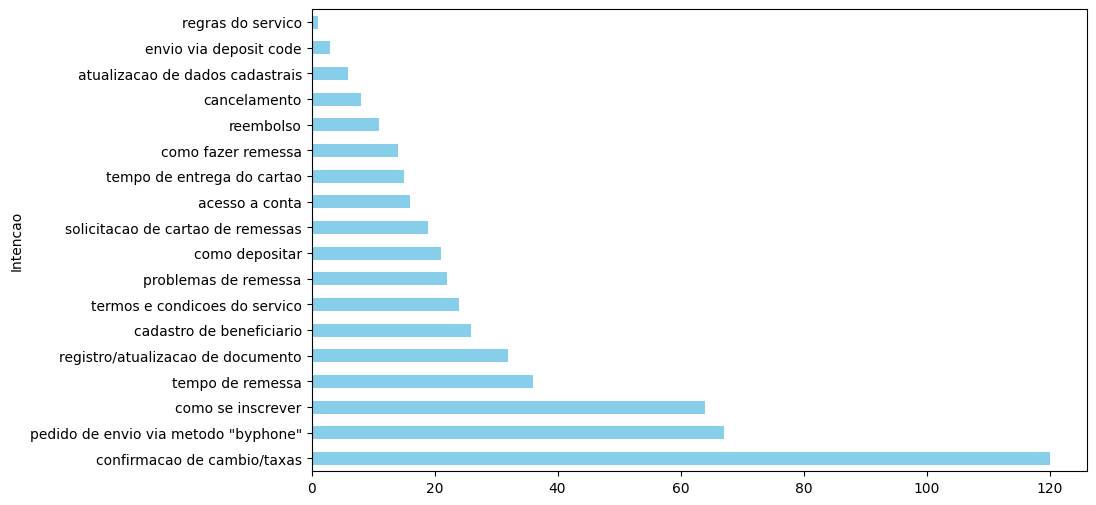

In [259]:
contagem = df_filtrado['Intencao'].value_counts()
plt.figure(figsize=(10, 6))
contagem.plot(kind='barh', color='skyblue')

plt.show()

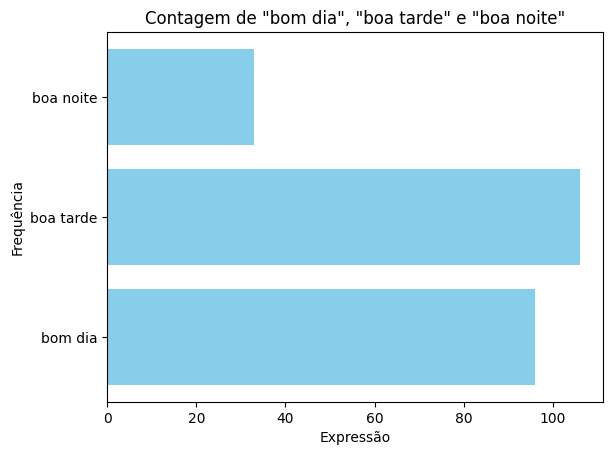

In [260]:
data = {
    'mensagens': [
        'bom dia',
        'boa tarde',
        'boa noite'
    ]
}

df = pd.DataFrame(data)

contagem = {
    'bom dia': df_filtrado['Pergunta'].str.contains('bom dia', case=False).sum(),
    'boa tarde': df_filtrado['Pergunta'].str.contains('boa tarde', case=False).sum(),
    'boa noite': df_filtrado['Pergunta'].str.contains('boa noite', case=False).sum()
}

plt.barh(list(contagem.keys()), list(contagem.values()), color=['skyblue'])
plt.xlabel('Expressão')
plt.ylabel('Frequência')
plt.title('Contagem de "bom dia", "boa tarde" e "boa noite"')
plt.show()

## Palavras que são mais escritas incorretamente

In [261]:
spell = SpellChecker(language='pt')
stop_words = set(stopwords.words('portuguese'))


def preprocessar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^\w\s]', '', texto)
    return texto

def encontrar_erros(texto):
    texto = preprocessar_texto(texto)
    palavras = texto.split()
    erros = [palavra for palavra in palavras if palavra not in stop_words and palavra not in spell]
    return erros

(array([ 0., 10., 20., 30., 40., 50., 60., 70., 80.]),
 [Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70'),
  Text(80.0, 0, '80')])

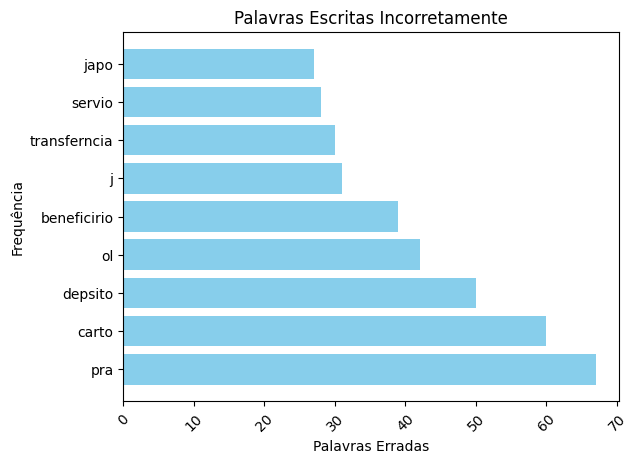

In [262]:
df_filtrado['erros'] = df_filtrado['Pergunta'].apply(lambda x: encontrar_erros(x))
todos_erros = [erro for sublist in df_filtrado['erros'] for erro in sublist]
contagem_erros = Counter(todos_erros)
top_erros = contagem_erros.most_common(10)[1:]
palavras, frequencias = zip(*top_erros)
plt.barh(list(palavras), list(frequencias), color='skyblue')
plt.xlabel('Palavras Erradas')
plt.ylabel('Frequência')
plt.title('Palavras Escritas Incorretamente')
plt.xticks(rotation=45)

## Gírias mais utilizadas pelos clientes

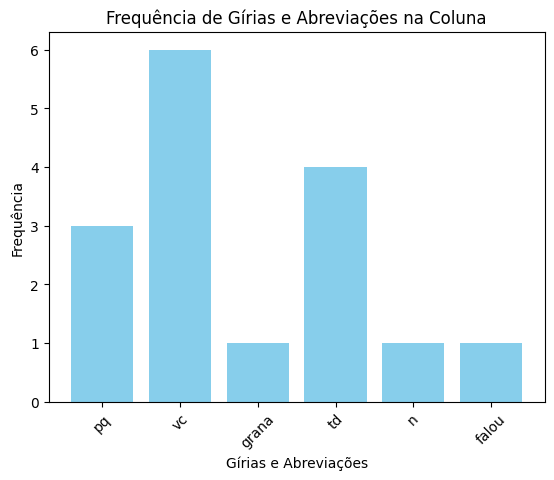

In [263]:
giras_abreviacoes = [
    "rolê", "zoar", "dahora", "massa", "mano", "man", "bicho", "treta", "falou",
    "sussa", "balada", "perifa", "bagulho", "cabuloso", "grana", "leco",
    "vc", "tb", "blz", "qnd", "pq", "ctz", "fds", "tbm", "mt", "flw", "n",
    "td", "tlg", "tá", "lol", "brb", "omg", "btw", "asap"
]

df_filtrado['giras_encontradas'] = df_filtrado['Pergunta'].apply(lambda x: verificar_giras_abreviacoes(x, giras_abreviacoes))

todos_giras = [giria for sublist in df_filtrado['giras_encontradas'] for giria in sublist]
contagem_giras = Counter(todos_giras)

plt.bar(contagem_giras.keys(), contagem_giras.values(), color='skyblue')
plt.xlabel('Gírias e Abreviações')
plt.ylabel('Frequência')
plt.title('Frequência de Gírias e Abreviações na Coluna')
plt.xticks(rotation=45)
plt.show()

## Pontuações mais frequentes nas perguntas

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128591 (\N{PERSON WITH FOLDED HANDS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


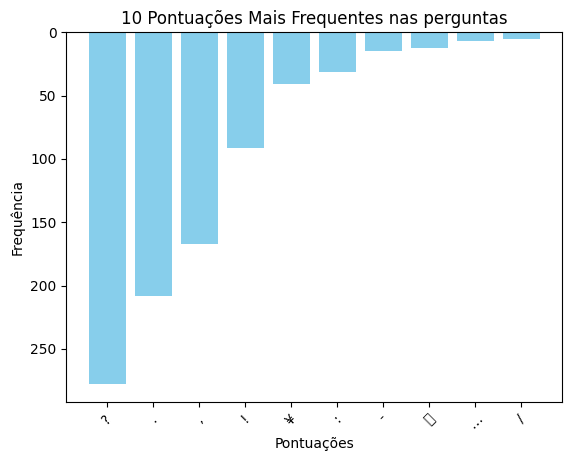

In [264]:
df = pd.read_excel(XLS_PATH)[['Intencao', 'Pergunta', 'Resposta\n']]

df['pontuacoes'] = df['Pergunta'].apply(contar_pontuacoes)

todas_pontuacoes = [ponto for sublist in df['pontuacoes'] for ponto in sublist]
contagem_pontuacoes = Counter(todas_pontuacoes)

top_10_pontuacoes = contagem_pontuacoes.most_common(10)

pontuacoes, frequencias = zip(*top_10_pontuacoes)

plt.bar(pontuacoes, frequencias, color='skyblue')
plt.xlabel('Pontuações')
plt.ylabel('Frequência')
plt.title('10 Pontuações Mais Frequentes nas perguntas')
plt.xticks(rotation=45)
plt.gca().invert_yaxis()

plt.show()

## Bigramas mais frequentes nas respostas ao cliente

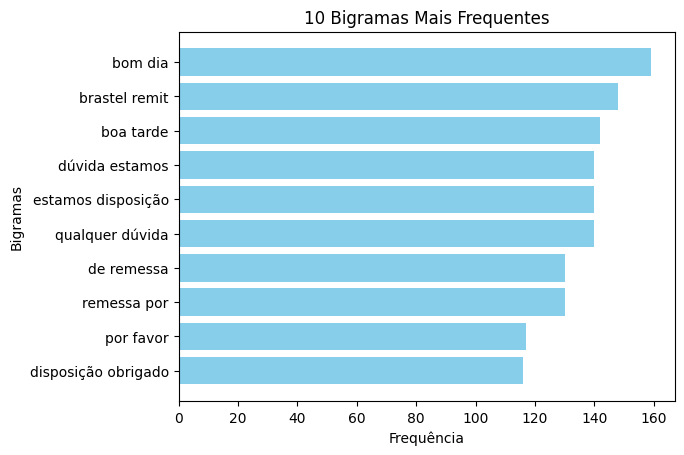

In [265]:
df['Resposta\n'] = df['Resposta\n'].fillna('')

todos_bigramas = Counter()
for texto in df['Resposta\n']:
    try:
        bigramas = encontrar_bigramas(texto)
        todos_bigramas.update(bigramas)
    except:
        pass

top_10_bigramas = todos_bigramas.most_common(10)

bigramas, frequencias = zip(*top_10_bigramas)

plt.barh(bigramas, frequencias, color='skyblue')
plt.xlabel('Frequência')
plt.ylabel('Bigramas')
plt.title('10 Bigramas Mais Frequentes')
plt.gca().invert_yaxis()
plt.show()

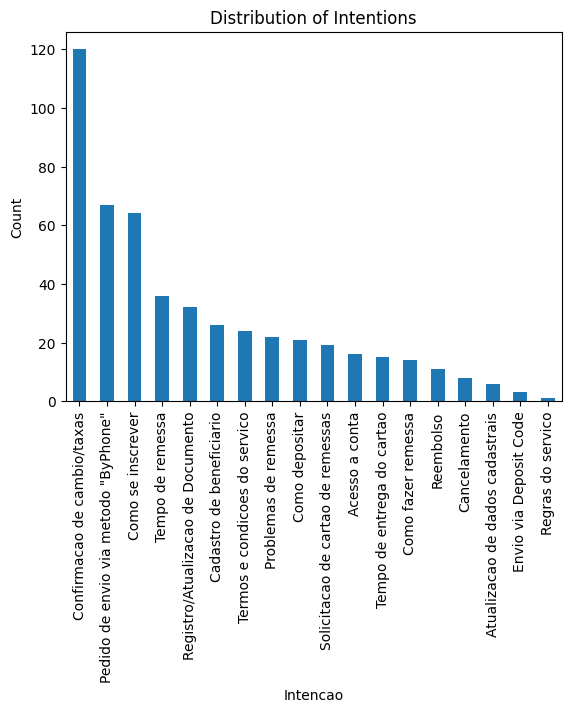

In [266]:
import matplotlib.pyplot as plt

df['Intencao'].value_counts().plot(kind='bar')
plt.xlabel('Intencao')
plt.ylabel('Count')
_ = plt.title('Distribution of Intentions')

#Definição de funções de etapas de pré-processamento

## lendo base de dados

In [267]:
file_path = CSV_PATH

headers = ["numero", "intencao", "pergunta", "resposta"]

csv_words = pd.read_csv(file_path, sep=";")

csv_words.shape

(981, 24)

In [268]:
csv_words.dropna(axis=1, how="all", inplace=True)
csv_words.dropna(axis=0, how="all", inplace=True)

csv_words.shape

(505, 4)

In [269]:
csv_words = csv_words.apply(lambda x: x.str.replace("\n", " ", regex=False) if x.dtype == "object" else x)
csv_words = csv_words.apply(lambda x: x.str.replace("\t", " ", regex=False) if x.dtype == "object" else x)
csv_words = csv_words.apply(lambda x: x.str.replace("\r", " ", regex=False) if x.dtype == "object" else x)
csv_words = csv_words.apply(lambda x: x.str.replace("\f", " ", regex=False) if x.dtype == "object" else x)
csv_words = csv_words.apply(lambda x: x.str.replace("\v", " ", regex=False) if x.dtype == "object" else x)

In [270]:
print(df.shape)
csv_words.head()

(505, 4)


,No,Intencao,Pergunta,Resposta\n
0,1.0,Como depositar,Boa dia.tudo bem?eu gostaria de saber sobre aq...,"Bom dia! Sim, o sr pode utilizar o cartão de d..."
1,2.0,Como fazer remessa,Como enviar dinheiro do Japão?,"Para se inscrever no serviço de remessa, por f..."
2,3.0,Tempo de remessa,Quanto tempo levará para o beneficiário recebe...,"Via de regra, as remessas serão pagas via PIX ..."
3,4.0,"Pedido de envio via metodo ""ByPhone""",Boa tarde Acabei de fazer a transferência de 2...,iremos processar a sua solicitacao. Muito obri...
4,5.0,"Pedido de envio via metodo ""ByPhone""",Poderia fazer a remessa de 22yenes para o BBB ...,iremos processar a sua solicitacao. Muito obri...


## Treinando tagger floresta

In [271]:
train_data = floresta.tagged_sents()
unigram_tagger = UnigramTagger(train_data)

## Definindo funções para o pré-processamento

In [272]:
def segmentar(texto):
    return sent_tokenize(texto, language='portuguese')

def tokenizar(texto):
    return word_tokenize(texto, language='portuguese')

def lematizar(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def stemming(tokens):
    stemmer = RSLPStemmer()
    stems = [stemmer.stem(token) for token in tokens]
    return stems

def remover_stopwords(tokens):
    stop_words = set(stopwords.words("portuguese"))
    filtered_text = [word for word in tokens if word.lower() not in stop_words]
    return filtered_text

def pos_tagging(tokens):
    return unigram_tagger.tag(tokens)

def remover_pontuacao(tokens):
    return [token for token in tokens if token not in string.punctuation]

def reconhecimento_entidades_nomeadas(tokens):
    pos_tags = nltk.pos_tag(tokens)
    named_entities = nltk.ne_chunk(pos_tags, binary=False)
    entities = []
    for subtree in named_entities:
        if isinstance(subtree, nltk.Tree):
            entity_name = " ".join([leaf[0] for leaf in subtree.leaves()])
            entity_type = subtree.label()
            entities.append((entity_name, entity_type))
    return entities

## Testes das funções de pré-processamento

In [273]:
# Texto de exemplo
texto = "O Leandro comprou um carro novo. Ele está muito feliz com a nova aquisição!"

In [274]:
# Teste da função segmentar
resultado_esperado_segmentar = ['O Leandro comprou um carro novo.', 'Ele está muito feliz com a nova aquisição!']
resultado_obtido_segmentar = segmentar(texto)
assert resultado_obtido_segmentar == resultado_esperado_segmentar, f"Erro no teste de segmentação. Esperado: {resultado_esperado_segmentar}, Obtido: {resultado_obtido_segmentar}"
print("Teste de segmentação passou!")

Teste de segmentação passou!


In [275]:
# Teste da função tokenizar
resultado_esperado_tokenizar = ['O', 'Leandro', 'comprou', 'um', 'carro', 'novo', '.', 'Ele', 'está', 'muito', 'feliz', 'com', 'a', 'nova', 'aquisição', '!']
resultado_obtido_tokenizar = tokenizar(texto)
assert resultado_obtido_tokenizar == resultado_esperado_tokenizar, f"Erro no teste de tokenização. Esperado: {resultado_esperado_tokenizar}, Obtido: {resultado_obtido_tokenizar}"
print("Teste de tokenização passou!")

Teste de tokenização passou!


In [276]:
# Teste da função lematizar
tokens_exemplo = ['Leandro', 'comprou', 'carros']
resultado_esperado_lematizar = ['Leandro', 'comprou', 'carros']
resultado_obtido_lematizar = lematizar(tokens_exemplo)
assert resultado_obtido_lematizar == resultado_esperado_lematizar, f"Erro no teste de lematização. Esperado: {resultado_esperado_lematizar}, Obtido: {resultado_obtido_lematizar}"
print("Teste de lematização passou!")

Teste de lematização passou!


In [277]:
# Teste da função stemming
resultado_esperado_stemming = ['leandr', 'compr', 'carr']
resultado_obtido_stemming = stemming(tokens_exemplo)
assert resultado_obtido_stemming == resultado_esperado_stemming, f"Erro no teste de stemming. Esperado: {resultado_esperado_stemming}, Obtido: {resultado_obtido_stemming}"
print("Teste de stemming passou!")

Teste de stemming passou!


In [278]:
# Teste da função remover_stopwords
resultado_esperado_remover_stopwords = ['Leandro', 'comprou', 'carros']
resultado_obtido_remover_stopwords = remover_stopwords(tokens_exemplo)
assert resultado_obtido_remover_stopwords == resultado_esperado_remover_stopwords, f"Erro no teste de remoção de stopwords. Esperado: {resultado_esperado_remover_stopwords}, Obtido: {resultado_obtido_remover_stopwords}"
print("Teste de remoção de stopwords passou!")

Teste de remoção de stopwords passou!


In [279]:
# Teste da função pos_tagging
resultado_esperado_pos_tagging = [('Leandro', 'N<+prop'), ('comprou', 'P+v-fin'), ('carros', 'H+n')]
resultado_obtido_pos_tagging = pos_tagging(tokens_exemplo)
assert resultado_obtido_pos_tagging == resultado_esperado_pos_tagging, f"Erro no teste de POS tagging. Esperado: {resultado_esperado_pos_tagging}, Obtido: {resultado_obtido_pos_tagging}"
print("Teste de POS tagging passou!")

Teste de POS tagging passou!


In [280]:
# Teste da função remover_pontuacao
tokens_com_pontuacao = ['Leandro', ',', 'comprou', 'carros', '.']
resultado_esperado_remover_pontuacao = ['Leandro', 'comprou', 'carros']
resultado_obtido_remover_pontuacao = remover_pontuacao(tokens_com_pontuacao)
assert resultado_obtido_remover_pontuacao == resultado_esperado_remover_pontuacao, f"Erro no teste de remoção de pontuação. Esperado: {resultado_esperado_remover_pontuacao}, Obtido: {resultado_obtido_remover_pontuacao}"
print("Teste de remoção de pontuação passou!")

Teste de remoção de pontuação passou!


In [281]:
# Teste da função reconhecimento_entidades_nomeadas
resultado_esperado_reconhecimento_entidades = [('Leandro', 'GPE')]
resultado_obtido_reconhecimento_entidades = reconhecimento_entidades_nomeadas(tokens_exemplo)
assert resultado_obtido_reconhecimento_entidades == resultado_esperado_reconhecimento_entidades, f"Erro no teste de reconhecimento de entidades nomeadas. Esperado: {resultado_esperado_reconhecimento_entidades}, Obtido: {resultado_obtido_reconhecimento_entidades}"
print("Teste de reconhecimento de entidades nomeadas passou!")

Teste de reconhecimento de entidades nomeadas passou!


#Uso de Pipeline de pré-processamento

## Definição da Pipeline

In [282]:
import random
from collections import Counter

def pipeline_preprocessamento(texto, aplicar_segmentacao=True, aplicar_tokenizacao=True, aplicar_lematizacao=True,
                              aplicar_stemming=True, aplicar_remocao_stopwords=True, aplicar_pos_tagging=True,
                              aplicar_reconhecimento_entidades=True, aplicar_remocao_pontuacao=True):
    if aplicar_segmentacao:
        sentencas = segmentar(texto)
    else:
        sentencas = [texto]

    all_tokens = []

    for sentenca in sentencas:
        if aplicar_tokenizacao:
            tokens = tokenizar(sentenca)
            if aplicar_lematizacao:
                tokens = lematizar(tokens)
            if aplicar_remocao_pontuacao:
                tokens = remover_pontuacao(tokens)
            if aplicar_remocao_stopwords:
                tokens = remover_stopwords(tokens)
            if aplicar_stemming:
                tokens = stemming(tokens)
            all_tokens.extend(tokens)

    bow_counter = Counter(all_tokens)

    used_random_numbers = set()

    resultados = []
    for sentenca in sentencas:
        print(f"Processing sentence: {sentenca}")

        output = {'Sentenca Original': sentenca}

        if aplicar_tokenizacao:
            tokens = tokenizar(sentenca)
            print(f"Tokens: {tokens}")

        if aplicar_lematizacao:
            tokens = lematizar(tokens)
            print(f"Lemmatized Tokens: {tokens}")

        if aplicar_reconhecimento_entidades:
            entidades = reconhecimento_entidades_nomeadas(tokens)
            print(f"Named Entities: {entidades}")
            named_entity_tokens = {entity[0] for entity in entidades}
        else:
            named_entity_tokens = set()

        if aplicar_remocao_pontuacao:
            tokens = remover_pontuacao(tokens)
            print(f"Tokens after Punctuation Removal: {tokens}")

        if aplicar_remocao_stopwords:
            tokens = remover_stopwords(tokens)
            print(f"Tokens after Stopword Removal: {tokens}")

        if aplicar_pos_tagging:
            pos_tags = pos_tagging(tokens)
            print(f"POS Tags: {pos_tags}")
            pos_tag_dict = {word: tag for word, tag in pos_tags}
        else:
            pos_tag_dict = {}

        if aplicar_stemming:
            stemmed_tokens = stemming(tokens)
            print(f"Stemmed Tokens: {stemmed_tokens}")

        sentence_counter = Counter(tokens)

        seen_tokens = set()
        combined_info = []
        for stem, token in zip(stemmed_tokens, tokens):
            if token not in seen_tokens:
                seen_tokens.add(token)
                is_named = True if token in named_entity_tokens else False
                pos = pos_tag_dict.get(token, "None")
                sentence_count = sentence_counter[token]

                random_number = random.randint(1, 1000)
                while random_number in used_random_numbers:
                    random_number = random.randint(1, 1000)
                used_random_numbers.add(random_number)

                combined_info.append([stem, is_named, pos, sentence_count, random_number])

        output['words'] = combined_info
        resultados.append(output)

        print("____________________________________________________________________________________________________")

    return resultados

## Lendo perguntas da base de dados para realização de testes

In [283]:
perguntas_concatenadas = ' '.join(csv_words['Pergunta'].dropna().astype(str))

perguntas_concatenadas = ' '.join(perguntas_concatenadas.split()[:1000])

print(perguntas_concatenadas)

Boa dia.tudo bem?eu gostaria de saber sobre aquele caixa do family mart verde eh 24 horas?e se eu posso transferir a qualquer hora?obrigado Como enviar dinheiro do Japão? Quanto tempo levará para o beneficiário receber o dinheiro? Boa tarde Acabei de fazer a transferência de 22+23, Total de 45Yenes Poderia fazer a remessa de 22yenes para o BBB RRR obrigado E de 23yenes para o AAAA MMMM VVVVV caixa econômica federal Obrigado Boa tarde Acabei de fazer uma transferência para conta de vocês no valor de 50.700 a ser descontado a taxa de vocês Boa tarde A beneficiária é YYY FFF YYY Como posso me inscrever no serviço de remessa? Boa noite gostaria de tirar uma dúvida???pq a cotação do dólar está 5,02 e no app está 4,96??? Bom dia! Hoje eu fiz um depósito! Acho que esqueci de digitar o código. Por favor Verifique pra mim. Fico no aguardo da confirmação! Obrigado Como posso me inscrever no serviço de remessa? Olá tudo bem, transferi um dinheiro do paypayginkou para essa conta mas não coloquei o

## Execução da pipeline

In [284]:
frase_teste = perguntas_concatenadas

resultados = pipeline_preprocessamento(frase_teste)

df_resultados = pd.DataFrame(resultados)

display(df_resultados)

Processing sentence: Boa dia.tudo bem?eu gostaria de saber sobre aquele caixa do family mart verde eh 24 horas?e se eu posso transferir a qualquer hora?obrigado Como enviar dinheiro do Japão?
Tokens: ['Boa', 'dia.tudo', 'bem', '?', 'eu', 'gostaria', 'de', 'saber', 'sobre', 'aquele', 'caixa', 'do', 'family', 'mart', 'verde', 'eh', '24', 'horas', '?', 'e', 'se', 'eu', 'posso', 'transferir', 'a', 'qualquer', 'hora', '?', 'obrigado', 'Como', 'enviar', 'dinheiro', 'do', 'Japão', '?']
Lemmatized Tokens: ['Boa', 'dia.tudo', 'bem', '?', 'eu', 'gostaria', 'de', 'saber', 'sobre', 'aquele', 'caixa', 'do', 'family', 'mart', 'verde', 'eh', '24', 'horas', '?', 'e', 'se', 'eu', 'posso', 'transferir', 'a', 'qualquer', 'hora', '?', 'obrigado', 'Como', 'enviar', 'dinheiro', 'do', 'Japão', '?']
Named Entities: [('Boa', 'GPE'), ('Como', 'ORGANIZATION'), ('Japão', 'PERSON')]
Tokens after Punctuation Removal: ['Boa', 'dia.tudo', 'bem', 'eu', 'gostaria', 'de', 'saber', 'sobre', 'aquele', 'caixa', 'do', 'fami

,Sentenca Original,words
0,Boa dia.tudo bem?eu gostaria de saber sobre aq...,"[[boa, True, H+adj, 1, 488], [dia.tud, False, ..."
1,Quanto tempo levará para o beneficiário recebe...,"[[quant, True, ADVL+pron-det, 1, 572], [temp, ..."
2,Boa tarde Acabei de fazer a transferência de 2...,"[[boa, True, H+adj, 3, 677], [tard, False, H+n..."
3,Boa noite gostaria de tirar uma dúvida??,"[[boa, True, H+adj, 1, 794], [noit, False, H+n..."
4,"?pq a cotação do dólar está 5,02 e no app está...","[[pq, False, None, 1, 259], [cot, False, H+n, ..."
5,Bom dia!,"[[bom, True, >A+adj, 1, 490], [dia, False, H+n..."
6,Hoje eu fiz um depósito!,"[[hoj, True, ADVL+adv, 1, 792], [fiz, False, P..."
7,Acho que esqueci de digitar o código.,"[[ach, True, P+v-fin, 1, 12], [esquec, False, ..."
8,Por favor Verifique pra mim.,"[[favor, False, H+n, 1, 476], [verifiqu, True,..."
9,Fico no aguardo da confirmação!,"[[fic, True, None, 1, 41], [aguard, False, Non..."


## Exibição de resultados obtidos

In [285]:
print(resultados)

[{'Sentenca Original': 'Boa dia.tudo bem?eu gostaria de saber sobre aquele caixa do family mart verde eh 24 horas?e se eu posso transferir a qualquer hora?obrigado Como enviar dinheiro do Japão?', 'words': [['boa', True, 'H+adj', 1, 488], ['dia.tud', False, None, 1, 449], ['bem', False, 'ADVL+adv', 1, 715], ['gost', False, 'P+v-fin', 1, 290], ['sab', False, 'P+v-inf', 1, 826], ['sobr', False, 'H+prp', 1, 864], ['caix', False, 'H+n', 1, 247], ['family', False, None, 1, 474], ['mart', False, None, 1, 579], ['verd', False, 'N<+adj', 1, 698], ['eh', False, None, 1, 452], ['24', False, '>N+num', 1, 997], ['hor', False, 'H+n', 1, 415], ['poss', False, 'AUX+v-fin', 1, 558], ['transfer', False, 'P+v-inf', 1, 613], ['qualqu', False, '>N+pron-det', 1, 624], ['hor', False, 'H+n', 1, 542], ['obrig', False, 'P+v-pcp', 1, 220], ['envi', False, 'P+v-inf', 1, 638], ['dinh', False, 'H+n', 1, 489], ['jap', True, 'H+prop', 1, 911]]}, {'Sentenca Original': 'Quanto tempo levará para o beneficiário receber 

In [286]:
for resultado in resultados:
    print(f"Sentence: {resultado['Sentenca Original']}")
    print("Words:")
    for word_info in resultado['words']:
        print(word_info)
    print("____________________________________________________________________________________________________")

Sentence: Boa dia.tudo bem?eu gostaria de saber sobre aquele caixa do family mart verde eh 24 horas?e se eu posso transferir a qualquer hora?obrigado Como enviar dinheiro do Japão?
Words:
['boa', True, 'H+adj', 1, 488]
['dia.tud', False, None, 1, 449]
['bem', False, 'ADVL+adv', 1, 715]
['gost', False, 'P+v-fin', 1, 290]
['sab', False, 'P+v-inf', 1, 826]
['sobr', False, 'H+prp', 1, 864]
['caix', False, 'H+n', 1, 247]
['family', False, None, 1, 474]
['mart', False, None, 1, 579]
['verd', False, 'N<+adj', 1, 698]
['eh', False, None, 1, 452]
['24', False, '>N+num', 1, 997]
['hor', False, 'H+n', 1, 415]
['poss', False, 'AUX+v-fin', 1, 558]
['transfer', False, 'P+v-inf', 1, 613]
['qualqu', False, '>N+pron-det', 1, 624]
['hor', False, 'H+n', 1, 542]
['obrig', False, 'P+v-pcp', 1, 220]
['envi', False, 'P+v-inf', 1, 638]
['dinh', False, 'H+n', 1, 489]
['jap', True, 'H+prop', 1, 911]
____________________________________________________________________________________________________
Sentence: Qu

In [287]:
data = []
for resultado in resultados:
    sentence = resultado['Sentenca Original']
    for word_info in resultado['words']:
        data.append({
            'Sentenca Original': sentence,
            'stemmed': word_info[0],
            'ent_nomeada': word_info[1],
            'pos_tagging': word_info[2],
            'ocorrencias': word_info[3],
            'id': word_info[4]
        })

df = pd.DataFrame(data)

display(df)

,Sentenca Original,stemmed,ent_nomeada,pos_tagging,ocorrencias,id
0,Boa dia.tudo bem?eu gostaria de saber sobre aq...,boa,True,H+adj,1,488
1,Boa dia.tudo bem?eu gostaria de saber sobre aq...,dia.tud,False,None,1,449
2,Boa dia.tudo bem?eu gostaria de saber sobre aq...,bem,False,ADVL+adv,1,715
3,Boa dia.tudo bem?eu gostaria de saber sobre aq...,gost,False,P+v-fin,1,290
4,Boa dia.tudo bem?eu gostaria de saber sobre aq...,sab,False,P+v-inf,1,826
...,...,...,...,...,...,...
605,Olá gostaria de saber mais sobre como enviar d...,sobr,False,H+prp,1,498
606,Olá gostaria de saber mais sobre como enviar d...,envi,False,P+v-inf,1,780
607,Olá gostaria de saber mais sobre como enviar d...,dinh,False,H+n,1,712
608,Olá gostaria de saber mais sobre como enviar d...,brasil,False,H+prop,1,78


## Testes de validação de Pipeline

In [288]:
def validate_word_info(word_info):
    """
    Este teste tem como objetivo realizar a validação dos arrays de resposta obtidos na pipe

    resultados esperados [String, Boolean, String, Int, Int]
    """
    if len(word_info) != 5:
        print(f"Tamanho de resposta errado: {word_info}")
        return False

    if not isinstance(word_info[0], str):
        print(f"Elemento de índice '0' deve ser do tipo 'String': {word_info}")
        return False

    if not isinstance(word_info[1], bool):
        print(f"Elemento de índice '1' deve ser do tipo 'Boolean': {word_info}")
        return False

    if not (word_info[2] is None or isinstance(word_info[2], str)):
        print(f"Elemento de índice '2' deve ser do tipo 'String: {word_info}")
        return False

    if not isinstance(word_info[3], int):
        print(f"Elemento de índice '3' deve ser do tipo 'Integer': {word_info}")
        return False

    if not isinstance(word_info[4], int):
        print(f"Elemento de índice '4' deve ser do tipo 'Integer': {word_info}")
        return False

    return True

def validate_results(resultados):
    all_valid = True
    for resultado in resultados:
        for word_info in resultado['words']:
            if not validate_word_info(word_info):
                all_valid = False
    return all_valid

is_valid = validate_results(resultados)
print(f"Os arrays são válidos? {is_valid}")


Os arrays são válidos? True


In [289]:
def testar_pipeline():
    """
    Este teste tem como objetivo a comparação entre resultados obtidos e esperados na execução da pipeline.
    """

    INPUT = "O Leandro comprou um carro novo. Ele está muito feliz com a nova aquisição!"

    result_esperado = [
        # Sentença 1 "O Leandro comprou um carro novo."
        [
            ['leandr', False, 'N<+prop', 1, 123],
            ['compr', False, 'P+v-fin', 1, 456],
            ['carr', False, 'H+n', 1, 789],
            ['nov', False, '>N+adj', 1, 321]
        ],

        # Sentença 2 "Ele está muito feliz com a nova aquisição!"
        [
            ['feliz', False, 'SC+adj', 1, 654],
            ['nov', False, '>N+adj', 1, 987],
            ['aquis', False, 'H+n', 1, 321]
        ]
    ]

    result_obtido = pipeline_preprocessamento(INPUT)

    sucesso = True

    print("🤖 Iniciando testes de pipeline... 🤖")

    print("____________________________________________________________________________________________________")

    for s_idx in range(len(result_esperado)):
        for i in range(len(result_esperado[s_idx])):
            obtido = result_obtido[s_idx]['words'][i][0:-1]
            esperado = result_esperado[s_idx][i][0:-1]
            print(f"Comparando: obtido='{obtido}', esperado='{esperado}'")
            try:
                assert obtido == esperado
                print("✅")
            except AssertionError:
                print("❌")
                sucesso = False
            print("____________________________________________________________________________________________________")

    print("")
    if sucesso:
        print("👍 Todos os testes passaram!")
    else:
        print("👎 Teste falhou!")

testar_pipeline()


Processing sentence: O Leandro comprou um carro novo.
Tokens: ['O', 'Leandro', 'comprou', 'um', 'carro', 'novo', '.']
Lemmatized Tokens: ['O', 'Leandro', 'comprou', 'um', 'carro', 'novo', '.']
Named Entities: []
Tokens after Punctuation Removal: ['O', 'Leandro', 'comprou', 'um', 'carro', 'novo']
Tokens after Stopword Removal: ['Leandro', 'comprou', 'carro', 'novo']
POS Tags: [('Leandro', 'N<+prop'), ('comprou', 'P+v-fin'), ('carro', 'H+n'), ('novo', '>N+adj')]
Stemmed Tokens: ['leandr', 'compr', 'carr', 'nov']
____________________________________________________________________________________________________
Processing sentence: Ele está muito feliz com a nova aquisição!
Tokens: ['Ele', 'está', 'muito', 'feliz', 'com', 'a', 'nova', 'aquisição', '!']
Lemmatized Tokens: ['Ele', 'está', 'muito', 'feliz', 'com', 'a', 'nova', 'aquisição', '!']
Named Entities: [('Ele', 'GPE')]
Tokens after Punctuation Removal: ['Ele', 'está', 'muito', 'feliz', 'com', 'a', 'nova', 'aquisição']
Tokens after S